In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from mpl_toolkits import mplot3d


import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight


from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import cartopy
import numpy as np
from cartopy.crs import PlateCarree
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_hist_gradient_boosting
from featurewiz import featurewiz


import warnings
warnings.filterwarnings('ignore')


In [223]:
#uncomment if this is the first time running the notebook
"""
url = 'https://services7.arcgis.com/oeoyTUJC8HEeYsRB/arcgis/rest/services/MDB_Wards_2016/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(url)
with open('data/mdb_data.json', 'w') as outfile:
    outfile.write(str(json.dumps(response.json())))
"""

"\nurl = 'https://services7.arcgis.com/oeoyTUJC8HEeYsRB/arcgis/rest/services/MDB_Wards_2016/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'\nresponse = requests.get(url)\nwith open('data/mdb_data.json', 'w') as outfile:\n    outfile.write(str(json.dumps(response.json())))\n"

In [351]:
ACCESS_KEY = '1a2febdd5530824a8bbc342c32aee3db'
provinces = [
    'Eastern Cape',
    'Free State',
    'Gauteng',
    'KwaZulu-Natal',
    'Limpopo',
    'Mpumalanga',
    'Northern Cape',
    'North West',
    'Western Cape',
]
prov_list=[]
for province in provinces:
    prov_dict={}
    url = 'http://api.positionstack.com/v1/forward?access_key=' + ACCESS_KEY+'&query='+province
    response = requests.get(url)
    prov_dict['province']=province
    prov_dict['lon']=response.json()['data'][0]['longitude']
    prov_dict['lat']=response.json()['data'][0]['latitude']
    prov_list.append(prov_dict)
print(prov_list)


[{'province': 'Eastern Cape', 'lon': 26.501313, 'lat': -32.19228}, {'province': 'Free State', 'lon': 26.682325, 'lat': -28.59211}, {'province': 'Gauteng', 'lon': 28.059764, 'lat': -26.238909}, {'province': 'KwaZulu-Natal', 'lon': 30.717503, 'lat': -28.453644}, {'province': 'Limpopo', 'lon': 29.341886, 'lat': -23.786037}, {'province': 'Mpumalanga', 'lon': 29.854636, 'lat': -26.375424}, {'province': 'Northern Cape', 'lon': 21.846696, 'lat': -29.46391}, {'province': 'North West', 'lon': 25.477234, 'lat': -26.701793}, {'province': 'Western Cape', 'lon': 19.760643, 'lat': -33.582933}]


In [379]:
from math import radians
from numpy import cos, sin, arcsin, sqrt
import haversine as hs
import requests
import json


# coordinates of major cities in Africa
cities_data = {
    'city': ['cape_town', 'Durban', 'Johannesburg', 'Soweto', 'Pretoria', 'Port_Elizabeth', 'PieterMaritzburg', 'Benoni', 'Tembisa', 'East_London', 'Vereeniging', 'Bloemfontein'],
    'lon': [18.423, 31.029, 28.044, 27.858, 28.188, 25.615, 30.393, 28.321, 28.227, 27.912, 27.926, 26.214],
    'lat': [-33.926, -29.858, -26.202, -26.268, -25.745, -33.961, -29.617, -26.188, -25.996, -33.015, -26.673, -29.121]
}


def haversine(row, city_index):
    #lon1 = cities_data['lon'][city_index]
    #lat1 = cities_data['lat'][city_index]
    lon1 = prov_list[city_index]['lon']
    lat1 = prov_list[city_index]['lat']
    lon2 = row['lon']
    lat2 = row['lat']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    km = 6367 * c
    return km


def within_radius(row, city_index):
    if haversine(row, city_index) < 150:
        return 1
    return 0


def process(filename):
    train_df = pd.read_csv('data/Train.csv')
    test_df = pd.read_csv('data/Test.csv')
    train_df['train'] = 1
    test_df['train'] = 0
    combined = pd.concat([train_df, test_df])
    combined = combined.drop(columns=['car_01', 'stv_01', 'lln_01', 'ward'])
    combined = combined.drop(columns=['ADM4_PCODE'])

    """for i in range(12):
        combined['dist_from_' +
            cities_data['city'][i]] = combined.apply(lambda row: haversine(row, i), axis=1)"""

    combined['dist_from_Johann'] = combined.apply(lambda row: haversine(row, 4), axis=1)
    #for i in range(len(prov_list)):
     #   combined['dist_from_'+prov_list[i]['province']] = combined.apply(lambda row: haversine(row, i), axis=1)

    combined['Household_Size'] = combined['total_individuals'] / \
        combined['total_households']
    """""

    with open('data/mdb_data.json') as json_file:
        mdb_data = json.load(json_file)
        mdb_df = pd.DataFrame.from_dict(pd.json_normalize(
            mdb_data['features']), orient='columns')
        mdb_df.drop(columns=['attributes.OBJECTID',
                    'geometry.rings'], inplace=True)
        combined = combined.join(mdb_df, lsuffix='ward', rsuffix='attributes.WardID').rename(columns=lambda x: x.replace("attributes.", "")).drop(columns=[
            'WardNumber', 'WardID', 'ProvinceCode', 'LocalMunicipalityCode', 'DistrictMunicipalityName', 'DistrictMunicipalityCode', 'Year', 'LocalMunicipalityName','ProvinceName'])
    combined['Shape__Area'] = combined['Shape__Area'].fillna(0)
    combined['Shape__Length'] = combined['Shape__Length'].fillna(0)
    combined['ProvinceName'] = combined['ProvinceName'].fillna('unknown')

    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(
        combined[['ProvinceName']]).toarray())
    encoder_df.columns = encoder.get_feature_names(['ProvinceName'])

    combined = combined.join(encoder_df)

    combined = combined.drop(columns=['ProvinceName'])"""

    if filename == 'data/Train.csv':
        return combined[combined.train == 1].drop(columns=['train'])
    elif filename == 'data/Test.csv':
        return combined[combined.train == 0].drop(columns=['train', 'target'])


In [371]:
data = process('data/Train.csv')
data.head()

,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL,Household_Size
0,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,...,0.002848,0.007537,0.000000,0.012928,0.0,0.0,-29.682270,24.734743,0.292039,3.516501
1,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,...,0.014566,0.057127,0.019092,0.004131,0.0,0.0,-29.119311,24.757737,3.207775,3.877587
2,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,...,0.057560,0.010358,0.001421,0.040881,0.0,0.0,-29.142276,25.094093,0.000000,3.025929
3,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,...,0.000000,0.000669,0.000000,0.005011,0.0,0.0,-29.372052,24.942867,2.038778,3.294194
4,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,...,0.004859,0.001290,0.000673,0.017629,0.0,0.0,-29.409381,25.290165,0.000000,3.846971


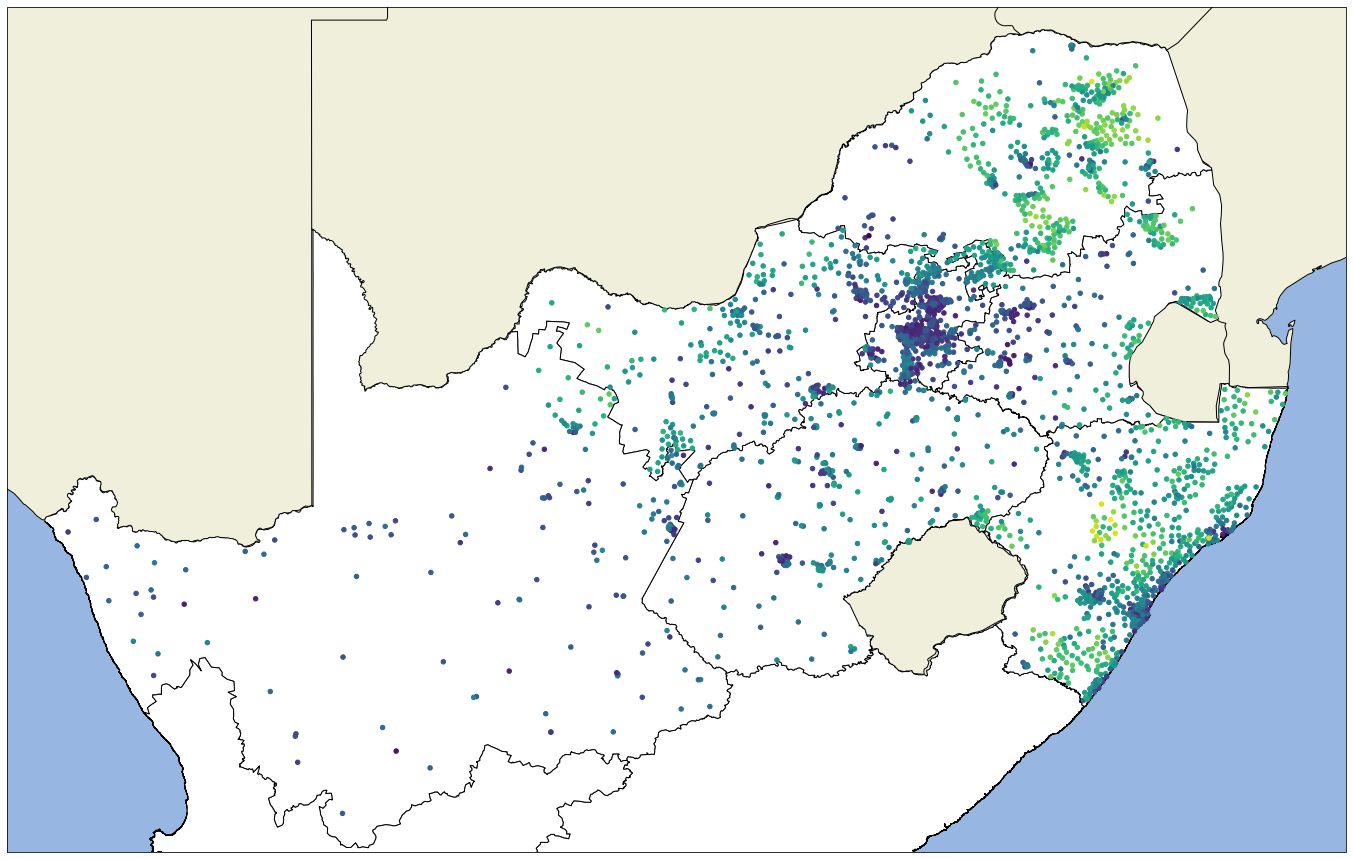

In [361]:
from cartopy.crs import LambertConformal, Mercator, Orthographic
import shapely
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

train_data = process('data/Train.csv')
test_data = process('data/Test.csv')


fname = 'data/shapefile/gadm40_ZAF_1.shp'
shapes = list(shpreader.Reader(fname).geometries())



# coordinates of major cities in Africa
cities_data = {
    'city': ['ref', 'Stellenbosch', 'cape_town', 'Durban', 'Johannesburg', 'Soweto', 'Pretoria', 'Port_Elizabeth', 'PieterMaritzburg', 'Benoni', 'Tembisa', 'East_London', 'Vereeniging', 'Bloemfontein'],
    'lon': [30.400, 18.860151, 18.423, 31.029, 28.044, 27.858, 28.188, 25.615, 30.393, 28.321, 28.227, 27.912, 27.926, 26.214],
    'lat': [-24.202, -33.932106, -33.926, -29.858, -26.202, -26.268, -25.745, -33.961, -29.617, -26.188, -25.996, -33.015, -26.673, -29.121]
}


def add_map_features():
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    ax.add_geometries(shapes,PlateCarree(),edgecolor='black',facecolor='white')


plt.figure(figsize=(24, 16))
central_lon, central_lat = -10, 45
extent = [-40, 20, 30, 60]
ax = plt.axes(projection=PlateCarree())

add_map_features()

ax.scatter(train_data['lon'], train_data['lat'], c=train_data['target'],
           transform=PlateCarree(),
           s=20,zorder=4
           )

"""ax.scatter(test_data['lon'], test_data['lat'], color='blue',# c=data['target'],
           transform=PlateCarree(),
           s=20,zorder=4
           )"""


"""for i in range(12):
    ax.text(cities_data['lon'][i], cities_data['lat'][i],
            cities_data['city'][i], transform=PlateCarree())
    ax.scatter(cities_data['lon'][i], cities_data['lat']
               [i], color='red', transform=PlateCarree(), s=30,zorder=4)"""

#ax.tissot(rad_km=250, lons=cities_data['lon'][0],
 #       lats=cities_data['lat'][0], alpha=0.4, color='red')



plt.show()


In [380]:
data= process('data/Train.csv')
X = data.drop(columns=['target'])
y= data[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0)

In [381]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print("RMSE", sqrt(mean_squared_error(y_test,xgb_grid.predict(X_test))))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.8906701778927345
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
RMSE 3.1276293432890405


In [382]:
ss = pd.read_csv('data/SampleSubmission.csv')
test = process('data/Test.csv')
ss['target'] = xgb_grid.predict(test)
version = 'johann&ref_dist'
ss.to_csv('submissions/'+version+'.csv', index=False)